### Load Data

In [5]:
import numpy as np                                       # fast vectors and matrices
import matplotlib.pyplot as plt                          # plotting
%matplotlib inline

import os
import sys
from scipy.fftpack import fft

#from intervaltree import Interval,IntervalTree

from time import time

import tensorflow as tf

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

DATA_PATH = '/home/Shared/cifar10'

/home/ec2-user/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ec2-user/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ec2-user/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ec2-user/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ec2-user/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


ImportError: No module named sklearn.metrics

In [2]:
# GPU stuff (dont use GPU2)
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='1'

In [3]:
############################## LOAD TRAIN DATA ################################
import cPickle
data_batches = []
label_batches = []
for batch_id in range(1,6):
    data_batch = cPickle.load(open(os.path.join(DATA_PATH, 'cifar-10-batches-py', 'data_batch_' + str(batch_id))))
    data_batches.append(data_batch['data'])
    label_batches.append(data_batch['labels'])

data_train_or = np.reshape(np.array(data_batches), (-1, 3, 32, 32)).transpose(0, 2, 3, 1)
data_train = data_train_or.astype(np.float32)
labels_train = np.array(label_batches).flatten()
print >> sys.stderr, 'data_train: ', data_train.shape
print >> sys.stderr,  'labels_train: ', labels_train.shape
num_gt_train = data_train.shape[0]


############################## LOAD TEST DATA #################################

data_batch = cPickle.load(open(os.path.join(DATA_PATH, 'cifar-10-batches-py', 'test_batch')))
data_test_or = np.reshape(data_batch['data'], (-1, 3, 32, 32)).transpose(0, 2, 3, 1)
data_test = data_test_or.astype(np.float32)
labels_test = np.array(data_batch['labels'])
print >> sys.stderr, 'data_test: ', data_test.shape
print >> sys.stderr, 'labels_test: ', labels_test.shape
num_gt_test = data_test.shape[0]


data_train:  (50000, 32, 32, 3)
labels_train:  (50000,)
data_test:  (10000, 32, 32, 3)
labels_test:  (10000,)


In [4]:
num_classes = 10
Ytrain = np.zeros((labels_train.shape[0],num_classes))
for i in range(labels_train.shape[0]):
    Ytrain[i,labels_train[i]] = 1
print Ytrain.shape

Ytest = np.zeros((labels_test.shape[0],num_classes))
for i in range(labels_test.shape[0]):
    Ytest[i,labels_test[i]] = 1
print Ytest.shape

(50000, 10)
(10000, 10)


In [5]:
data_train=data_train_or.astype(np.float64)
Xmeans=np.zeros((np.shape(data_train)[0],1,1,1))
Xmeans[:,0,0,0]=np.mean(data_train,axis=(1,2,3))
print Xmeans.shape
data_train=data_train-Xmeans

Xnorms=np.zeros((np.shape(data_train)[0],1,1,1))
Xnorms[:,0,0,0]=np.sqrt(np.sum(data_train**2,axis=(1,2,3)))+1e-10
data_train=data_train/Xnorms
print data_train.shape
print np.mean(data_train)
print np.linalg.norm(data_train[:])**2

data_test=data_test_or.astype(np.float64)
Xmeans=np.zeros((np.shape(data_test)[0],1,1,1))
Xmeans[:,0,0,0]=np.mean(data_test,axis=(1,2,3))
data_test=data_test-Xmeans

Xnorms=np.zeros((np.shape(data_test)[0],1,1,1))
Xnorms[:,0,0,0]=np.sqrt(np.sum(data_test**2,axis=(1,2,3)))+1e-10
data_test=data_test/Xnorms
print data_test.shape
print np.mean(data_test)
print np.linalg.norm(data_test[:])**2


(50000, 1, 1, 1)
(50000, 32, 32, 3)
-7.852514934588347e-21
49999.99999999489
(10000, 32, 32, 3)
2.726407063076882e-20
9999.999999998834


### Constants

In [6]:
batch_size = 200
win_size = 4
win_size_lvl2 = 8
win_size_lvl3 = 8

pad_size = 4

dim_cut_off = (3*win_size**2)/2

num_fils_lvl1 = 64
num_fils_lvl2 = 512
num_fils_lvl2_down = 128
num_fils_lvl3 = 512

im_size = 32

pool_size=2
pool_stride=2

print dim_cut_off

24


In [7]:
def stand(x):

    x=x-np.min(x[:])
    x=x/(np.max(x[:])+1e-12)

    return x

In [8]:
def compute_class_error(Y,Yhat):

    indsYhat=np.argmax(Yhat,axis=1)

    indsY=np.argmax(Y,axis=1)

    errors = (indsYhat-indsY)!=0

    return 100*sum(errors)/(Yhat.shape[0]*1.0)

In [9]:
def data_aug(X,pad_param):
    Xout=np.zeros((np.shape(X)[0],32,32,3),dtype=np.float32)
    X = np.pad(X,[[0,0],[pad_param,pad_param],[pad_param,pad_param],[0,0]],'constant')
    for ind in range(X.shape[0]):
        i=np.random.randint(0,2*pad_param)
        j=np.random.randint(0,2*pad_param)
        if np.random.randint(0,2)>0.5:
            Xout[ind,:,:,:] = X[ind,i:(i+im_size),j:(j+im_size),:]
        else:
            Xout[ind,:,:,:] = np.flip(X[ind,i:(i+im_size),j:(j+im_size),:],1)
    
    return Xout


### Make data

In [10]:
Xtrain=np.zeros((np.shape(data_train)[0],32,32,3),dtype=np.float32)
Xtrain[:,:,:,:]=data_train
print Xtrain.shape

Xtest=np.zeros((np.shape(data_test)[0],32,32,3),dtype=np.float32)
Xtest[:,:,:,:]=data_test
print Xtest.shape

(50000, 32, 32, 3)
(10000, 32, 32, 3)


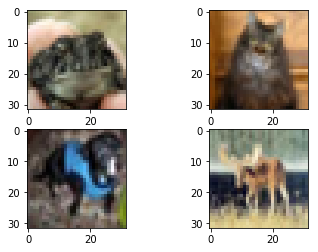

In [11]:
ind=25
plt.subplot(221)
plt.imshow(stand(Xtrain[ind,:,:,:]))
plt.subplot(222)
plt.imshow(stand(Xtrain[ind+1,:,:,:]))
plt.subplot(223)
plt.imshow(stand(Xtrain[ind+2,:,:,:]))
plt.subplot(224)
plt.imshow(stand(Xtrain[ind+3,:,:,:]))

### PCA

In [12]:
print win_size
#window_use = np.zeros((1,1,win_size,win_size))
#window_use[0,0,:,:] = window

num_samples=50000
start_ind=5
end_ind=15
step=1
print np.size(range(start_ind,end_ind,step))**2        

cov = np.zeros((3*win_size**2,3*win_size**2),dtype=np.float64)
for start_ind_x in range(start_ind,end_ind,step):
    print start_ind_x
    for start_ind_y in range(start_ind,end_ind,step):
        sample_patches = Xtrain[0:num_samples,start_ind_x:(start_ind_x+win_size),start_ind_y:(start_ind_y+win_size),:]
        #sample_patches=window_use*sample_patches
        sample_patches=np.reshape(sample_patches,(num_samples, 3*win_size**2))
        cov += np.matmul(np.transpose(sample_patches),sample_patches)

cov = cov/(num_samples*np.size(range(start_ind,end_ind,step))**2)

U, D, V = np.linalg.svd(cov, full_matrices=False)
print U.shape, D.shape, V.shape

#V=np.reshape(V,(win_size,win_size,3,3*win_size**2))
V=np.reshape(V,(3*win_size**2,win_size,win_size,3))
print V.shape
print D[0:10]

for i in range(3*win_size**2):
    V[i,:,:,:] /= np.sqrt(D[i]+D[dim_cut_off])

#print V[0,:,:,:]




4
100
5
6
7
8
9
10
11
12
13
14
(48, 48) (48,) (48, 48)
(48, 4, 4, 3)
[0.00958135 0.00192029 0.00160905 0.00125891 0.00039276 0.00036635
 0.000308   0.00030457 0.00013997 0.00013589]


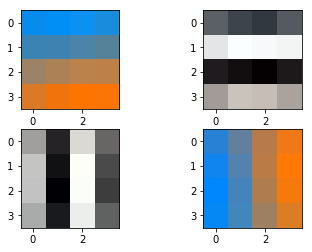

In [13]:
ind=10
plt.subplot(221)
plt.imshow(stand(V[ind,:,:,:]))
plt.subplot(222)
plt.imshow(stand(V[ind+1,:,:,:]))
plt.subplot(223)
plt.imshow(stand(V[ind+2,:,:,:]))
plt.subplot(224)
plt.imshow(stand(V[ind+3,:,:,:]))

### make TF graph

In [14]:
V=np.reshape(V,(3*win_size**2,3*win_size**2))
V = V.astype(np.float32)
print V.shape

(48, 48)


In [15]:
tf.reset_default_graph()
tf.set_random_seed(999)

lr_param = tf.placeholder(tf.float32,shape=[])
mom_param = tf.placeholder(tf.float32,shape=[])
reg_param = tf.placeholder(tf.float32,shape=[])


x = tf.placeholder(tf.float32, shape=[None,im_size,im_size,3])
y = tf.placeholder(tf.float32, shape=[None, num_classes])

wscale = 0.1
filters_use = tf.Variable(wscale*tf.random_normal([3*win_size**2,num_fils_lvl1],seed=999))
filters_lvl2 = tf.Variable(wscale*tf.random_normal([win_size_lvl2,win_size_lvl2,num_fils_lvl1,num_fils_lvl2],seed=999))
filters_lvl2_down_1 = tf.Variable(wscale*tf.random_normal([1,1,num_fils_lvl2,num_fils_lvl2_down],seed=999))
filters_lvl3_1 = tf.Variable(wscale*tf.random_normal([win_size_lvl3,win_size_lvl3,num_fils_lvl2_down,num_fils_lvl3],seed=999))
beta = tf.Variable(wscale*tf.random_normal([num_fils_lvl3,num_classes],seed=999))
filters_lvl2_down_2 = tf.Variable(wscale*tf.random_normal([1,1,num_fils_lvl2,num_fils_lvl2_down],seed=999))
filters_lvl3_2 = tf.Variable(wscale*tf.random_normal([win_size_lvl3,win_size_lvl3,num_fils_lvl2_down,num_fils_lvl3],seed=999))
beta_2 = tf.Variable(wscale*tf.random_normal([num_fils_lvl3,num_classes],seed=999))


regularizer = tf.nn.l2_loss(beta)+tf.nn.l2_loss(beta_2)+tf.nn.l2_loss(filters_use)+\
    tf.nn.l2_loss(filters_lvl2)+tf.nn.l2_loss(filters_lvl2_down_1)+tf.nn.l2_loss(filters_lvl3_1)+\
    tf.nn.l2_loss(filters_lvl2_down_2)+tf.nn.l2_loss(filters_lvl3_2)

filters_lvl1 = tf.matmul(V.T,filters_use)
filters_lvl1 = tf.reshape(filters_lvl1,[win_size,win_size,3,num_fils_lvl1])

x_feats_lvl1 = tf.nn.conv2d(x,filters_lvl1,strides=[1,1,1,1],padding='SAME')
x_feats_lvl1 = tf.nn.relu(x_feats_lvl1)

x_feats_lvl2 = tf.nn.conv2d(x_feats_lvl1,filters_lvl2,strides=[1,1,1,1],padding='SAME')
x_feats_lvl2 = tf.nn.relu(x_feats_lvl2)

x_feats_lvl3 = tf.nn.avg_pool(x_feats_lvl2,ksize=[1,pool_size,pool_size,1],\
                         strides=[1,pool_stride,pool_stride,1],padding='SAME')

x_feats_lvl3 = tf.nn.conv2d(x_feats_lvl3,filters_lvl2_down_1,strides=[1,1,1,1],padding='SAME')
x_feats_lvl3 = tf.nn.conv2d(x_feats_lvl3,filters_lvl3_1,strides=[1,1,1,1],padding='SAME')
x_feats_lvl3 = tf.nn.relu(x_feats_lvl3)

x_feats_tmp = tf.reduce_sum(x_feats_lvl3,axis=[1,2])/(num_fils_lvl2*im_size**2)
y_hat = tf.matmul(x_feats_tmp,beta)

x_feats_lvl3 = tf.nn.avg_pool(x_feats_lvl2,ksize=[1,pool_size**2,pool_size**2,1],\
                         strides=[1,pool_stride**2,pool_stride**2,1],padding='SAME')

x_feats_lvl3 = tf.nn.conv2d(x_feats_lvl3,filters_lvl2_down_2,strides=[1,1,1,1],padding='SAME')
x_feats_lvl3 = tf.nn.conv2d(x_feats_lvl3,filters_lvl3_2,strides=[1,1,1,1],padding='SAME')
x_feats_lvl3 = tf.nn.relu(x_feats_lvl3)

x_feats_tmp = tf.reduce_sum(x_feats_lvl3,axis=[1,2])/(num_fils_lvl2*im_size**2)
y_hat = y_hat + tf.matmul(x_feats_tmp,beta_2)


L = tf.reduce_mean(tf.nn.l2_loss(y_hat-y) + reg_param * regularizer) 

opt = tf.train.MomentumOptimizer(lr_param,mom_param)
train_step = opt.minimize(L)

init = tf.global_variables_initializer()

In [16]:
square_error = []
class_error = []
square_error_train = []
class_error_train = []

norm_filters = []
norm_beta = []

num_iter = 1
all_iter = []
all_lr = []

use_inds_train = np.random.randint(Xtrain.shape[0],size=(4000))
Xtrain_subset = Xtrain[use_inds_train,:,:]
Ytrain_subset = Ytrain[use_inds_train,:]

sess = tf.Session()
sess.run(init)

### Learn

In [17]:
tmp_var=sess.run(x_feats_lvl1, feed_dict={x: Xtrain[0:100,:,:,:]})
print tmp_var.shape
print np.mean(tmp_var[:])
print np.mean(np.sum(tmp_var**2,axis=(1)))
print np.mean(tmp_var**2)
print np.sqrt(np.mean(tmp_var**2))
tmp_var=sess.run(y_hat, feed_dict={x: Xtrain[0:100,:,:,:]})
print tmp_var.shape

(100, 32, 32, 64)
0.1903666
4.5204906
0.14126538
0.37585285
(100, 10)


In [18]:
if np.size(all_iter) > 11:
    print np.size(class_error)
    print class_error[-20:]
    print all_iter[-1]
    print np.min(class_error[:])

In [27]:
max_iter=100000
i_save=200

reg_lambda=0.0001
lr = 0.1/2/2

mom = 0.9

np.random.seed(999)
start = time()
print 'iter\tepoch\tsquare_loss\tclass_loss\tnorm_beta\ttime\teval_time'
for i in xrange(max_iter):
    if i % i_save == 0 and (i != 0 or len(square_error) == 0):
        eval_time = time()        
        all_iter.append(num_iter)
        all_lr.append(lr)

        # split up test set
        se = 0.
        subdiv = 200
        subset = Xtest.shape[0]/subdiv
        Yhat_test = np.empty((Xtest.shape[0],num_classes))
        for j in range(subdiv):
            se += sess.run(L, feed_dict={x: Xtest[subset*j:subset*(j+1)], y: Ytest[subset*j:subset*(j+1)], reg_param: reg_lambda})/subset
            Yhat_test[subset*j:subset*(j+1)] = sess.run(y_hat,feed_dict={x: Xtest[subset*j:subset*(j+1)]})
        square_error.append(se/subdiv)
        class_error.append(compute_class_error(Ytest, Yhat_test))
        
        # split up train set
        se = 0.
        subdiv = 200
        subset = Xtrain_subset.shape[0]/subdiv
        Yhat_train_subset = np.empty((Xtrain_subset.shape[0],num_classes))
        for j in range(subdiv):
            se += sess.run(L, feed_dict={x: Xtrain_subset[subset*j:subset*(j+1)], y: Ytrain_subset[subset*j:subset*(j+1)], reg_param: reg_lambda})/subset
            Yhat_train_subset[subset*j:subset*(j+1)] = sess.run(y_hat,feed_dict={x: Xtrain_subset[subset*j:subset*(j+1)]})
        square_error_train.append(se/subdiv)
        class_error_train.append(compute_class_error(Ytrain_subset, Yhat_train_subset))

        fils_norm = np.mean(np.linalg.norm(filters_lvl1.eval(session=sess),axis=0))
        norm_filters.append(fils_norm)
        norm_beta.append(np.mean(np.linalg.norm(beta.eval(session=sess),axis=0)))

        
        end = time()
        print num_iter,\
                '\t', num_iter*batch_size/(Xtrain.shape[0]+0.0),\
                '\t', square_error[-1],\
                '\t', class_error[-1],\
                '\t', norm_beta[-1],\
                '\t',end-start,\
                '\t',end-eval_time
        start = time()    
       
    use_inds = np.random.randint(Xtrain.shape[0],size=(batch_size))
    Xmb = Xtrain[use_inds,:,:]
    Ymb = Ytrain[use_inds,:]
    Xmb = data_aug(Xmb,pad_size)
                        
    sess.run(train_step, feed_dict={x: Xmb, y: Ymb, lr_param: lr, mom_param: mom, reg_param: reg_lambda})
    num_iter+=1

iter	epoch	square_loss	class_loss	norm_beta	time	eval_time
17575 	70.3 	0.21300252790451052 	9.02 	16.08654 	67.0153048038 	17.2204928398
17775 	71.1 	0.21265597963333127 	8.83 	16.091099 	67.5909750462 	17.2988550663
17975 	71.9 	0.21191991291046153 	8.82 	16.108076 	67.343611002 	17.2635028362
18175 	72.7 	0.20995231294631952 	9.14 	16.12692 	67.6111412048 	17.2390770912
18375 	73.5 	0.20851030101776127 	9.08 	16.153862 	67.5383448601 	17.2571208477
18575 	74.3 	0.20665759286880492 	8.92 	16.18039 	67.455051899 	17.2237927914
18775 	75.1 	0.20787580232620237 	8.96 	16.209564 	67.2813200951 	17.0055711269
18975 	75.9 	0.20860885620117176 	8.83 	16.238327 	67.6678609848 	17.0731761456
19175 	76.7 	0.20523605661392208 	8.82 	16.268332 	67.2701160908 	17.0746679306
19375 	77.5 	0.20556131687164306 	8.92 	16.305017 	67.5629968643 	17.2307100296
19575 	78.3 	0.20612209548950194 	8.68 	16.336931 	67.4777829647 	17.1966230869
19775 	79.1 	0.2038146058559418 	8.79 	16.37321 	67.3120408058 	17

KeyboardInterrupt: 

107
tst class  error: 8.68
tst square error: 0.2007333255767822
trn class  error: 0.0
trn square error: 0.2547776501178741


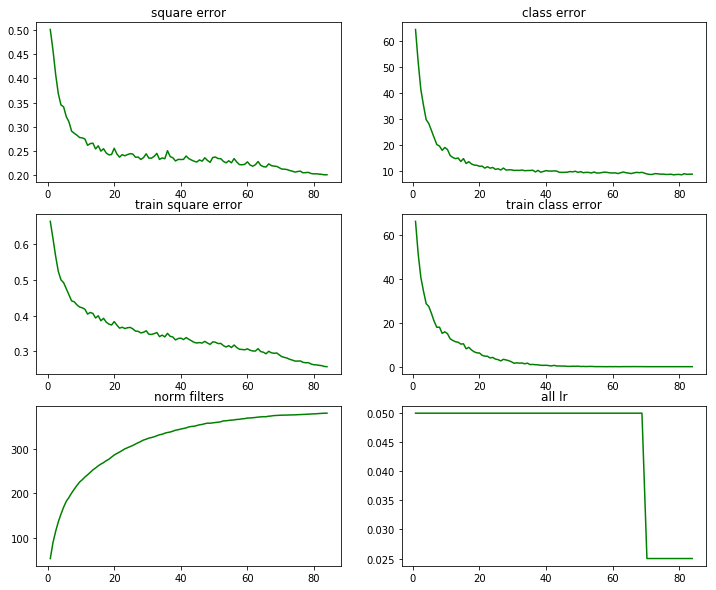

In [28]:
burnin=1
end_iter = len(class_error)-2
print len(class_error)
fig, ((ax1, ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3, 2)
fig.set_figwidth(12)
fig.set_figheight(10)
x_tics = np.asarray(all_iter[burnin:end_iter],dtype=np.float32)*batch_size/(Xtrain.shape[0]+0.0)
ax1.set_title('square error')
ax1.plot(x_tics,square_error[burnin:end_iter],color='g')
ax2.set_title('class error')
ax2.plot(x_tics,class_error[burnin:end_iter],color='g')
ax3.set_title('train square error')
ax3.plot(x_tics,square_error_train[burnin:end_iter],color='g')
ax4.set_title('train class error')
ax4.plot(x_tics,class_error_train[burnin:end_iter],color='g')
ax5.set_title('norm filters')
ax5.plot(x_tics,norm_filters[burnin:end_iter],color='g')
#ax6.set_title('norm beta')
#ax6.plot(x_tics,norm_beta[burnin:end_iter],color='g')
ax6.set_title('all lr')
ax6.plot(x_tics,all_lr[burnin:end_iter],color='g')
print 'tst class  error:', + min(class_error)
print 'tst square error:', + min(square_error)
print 'trn class  error:', + min(class_error_train)
print 'trn square error:', + min(square_error_train)

107
tst class  error: 8.68
tst square error: 0.2007333255767822
trn class  error: 0.0
trn square error: 0.2547776501178741


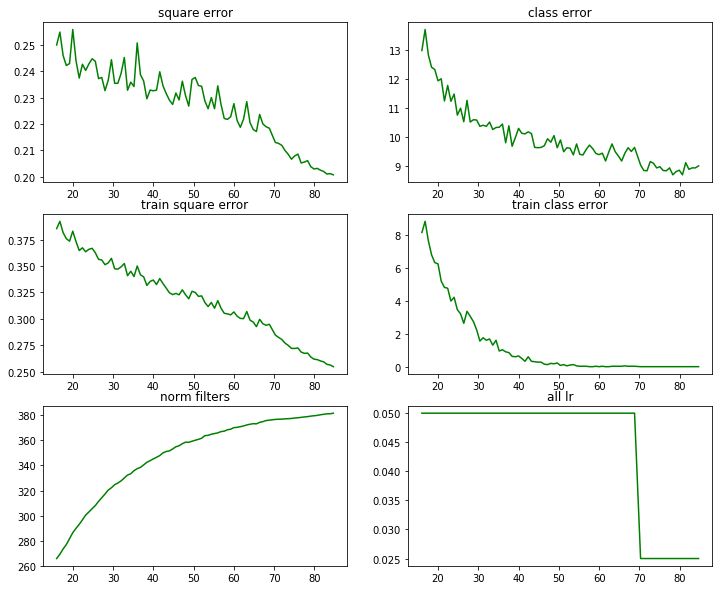

In [29]:
burnin=20
end_iter = len(class_error)-1
print len(class_error)
fig, ((ax1, ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3, 2)
fig.set_figwidth(12)
fig.set_figheight(10)
x_tics = np.asarray(all_iter[burnin:end_iter],dtype=np.float32)*batch_size/(Xtrain.shape[0]+0.0)
ax1.set_title('square error')
ax1.plot(x_tics,square_error[burnin:end_iter],color='g')
ax2.set_title('class error')
ax2.plot(x_tics,class_error[burnin:end_iter],color='g')
ax3.set_title('train square error')
ax3.plot(x_tics,square_error_train[burnin:end_iter],color='g')
ax4.set_title('train class error')
ax4.plot(x_tics,class_error_train[burnin:end_iter],color='g')
ax5.set_title('norm filters')
ax5.plot(x_tics,norm_filters[burnin:end_iter],color='g')
#ax6.set_title('norm beta')
#ax6.plot(x_tics,norm_beta[burnin:end_iter],color='g')
ax6.set_title('all lr')
ax6.plot(x_tics,all_lr[burnin:end_iter],color='g')
print 'tst class  error:', + min(class_error)
print 'tst square error:', + min(square_error)
print 'trn class  error:', + min(class_error_train)
print 'trn square error:', + min(square_error_train)

107
tst class  error: 8.68
tst square error: 0.2007333255767822
trn class  error: 0.0
trn square error: 0.2547776501178741


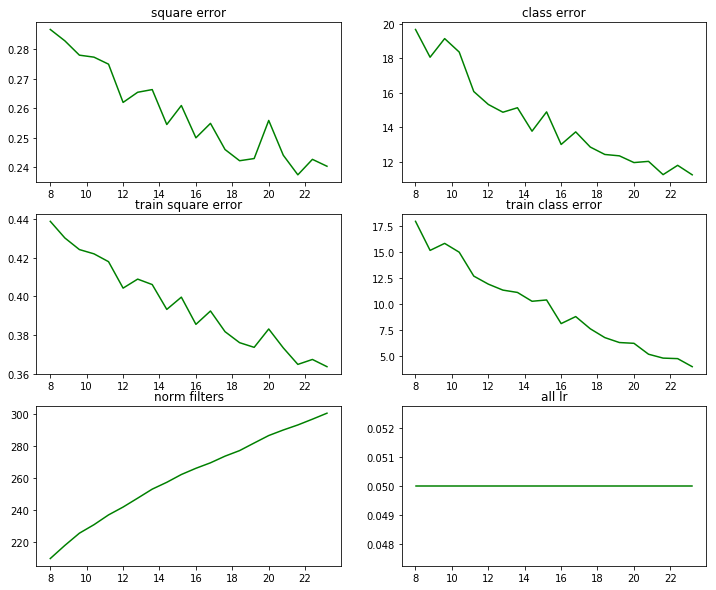

In [30]:
burnin=10
end_iter = 30
print len(class_error)
fig, ((ax1, ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3, 2)
fig.set_figwidth(12)
fig.set_figheight(10)
x_tics = np.asarray(all_iter[burnin:end_iter],dtype=np.float32)*batch_size/(Xtrain.shape[0]+0.0)
ax1.set_title('square error')
ax1.plot(x_tics,square_error[burnin:end_iter],color='g')
ax2.set_title('class error')
ax2.plot(x_tics,class_error[burnin:end_iter],color='g')
ax3.set_title('train square error')
ax3.plot(x_tics,square_error_train[burnin:end_iter],color='g')
ax4.set_title('train class error')
ax4.plot(x_tics,class_error_train[burnin:end_iter],color='g')
ax5.set_title('norm filters')
ax5.plot(x_tics,norm_filters[burnin:end_iter],color='g')
#ax6.set_title('norm beta')
#ax6.plot(x_tics,norm_beta[burnin:end_iter],color='g')
ax6.set_title('all lr')
ax6.plot(x_tics,all_lr[burnin:end_iter],color='g')
print 'tst class  error:', + min(class_error)
print 'tst square error:', + min(square_error)
print 'trn class  error:', + min(class_error_train)
print 'trn square error:', + min(square_error_train)

(4, 4, 3, 64)


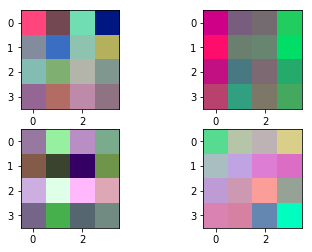

In [31]:
fils_tmp=filters_lvl1.eval(session=sess)
print fils_tmp.shape

ind=24
plt.subplot(221)
plt.imshow(stand(fils_tmp[:,:,:,ind]))
plt.subplot(222)
plt.imshow(stand(fils_tmp[:,:,:,ind+1]))
plt.subplot(223)
plt.imshow(stand(fils_tmp[:,:,:,ind+2]))
plt.subplot(224)
plt.imshow(stand(fils_tmp[:,:,:,ind+3]))



(8, 8, 64, 512)


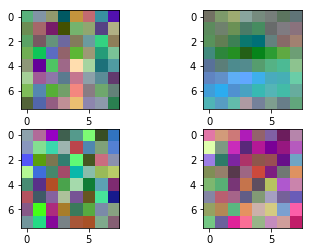

In [32]:
fils_tmp=filters_lvl2.eval(session=sess)
fils_tmp=fils_tmp.reshape((win_size_lvl2,win_size_lvl2,num_fils_lvl1,num_fils_lvl2))
print fils_tmp.shape

ind=3
plt.subplot(221)
plt.imshow(stand(fils_tmp[:,:,0:3,ind]))
plt.subplot(222)
plt.imshow(stand(fils_tmp[:,:,1:4,ind+1]))
plt.subplot(223)
plt.imshow(stand(fils_tmp[:,:,2:5,ind+2]))
plt.subplot(224)
plt.imshow(stand(fils_tmp[:,:,3:6,ind+3]))



(4, 4, 3, 64)
(8, 8, 64, 512)


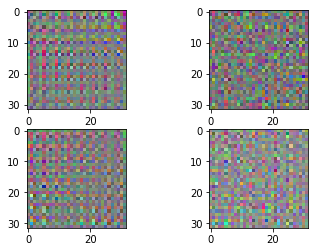

In [33]:
fils_tmp_lvl2=filters_lvl2.eval(session=sess)
fils_tmp_lvl2=fils_tmp_lvl2.reshape((win_size_lvl2,win_size_lvl2,num_fils_lvl1,num_fils_lvl2))
fils_tmp_lvl1=filters_lvl1.eval(session=sess)
print fils_tmp_lvl1.shape
print fils_tmp_lvl2.shape


fils_tmp_lvl1=np.reshape(fils_tmp_lvl1,(win_size*win_size*3,num_fils_lvl1))
fils_tmp = np.zeros((win_size*win_size_lvl2,win_size*win_size_lvl2,3,num_fils_lvl2))

for i in range(win_size_lvl2):
    for j in range(win_size_lvl2):
        fils_proj = np.matmul(fils_tmp_lvl1,fils_tmp_lvl2[i,j,:,:])
        fils_proj = np.reshape(fils_proj,(win_size,win_size,3,num_fils_lvl2))        
        fils_tmp[(i*win_size):(i*win_size+win_size),(j*win_size):(j*win_size+win_size),:,:] = fils_proj

ind=0
plt.subplot(221)
plt.imshow(stand(fils_tmp[:,:,:,ind]))
plt.subplot(222)
plt.imshow(stand(fils_tmp[:,:,:,ind+1]))
plt.subplot(223)
plt.imshow(stand(fils_tmp[:,:,:,ind+2]))
plt.subplot(224)
plt.imshow(stand(fils_tmp[:,:,:,ind+3]))



(4, 4, 3, 64)
(8, 8, 64, 512)


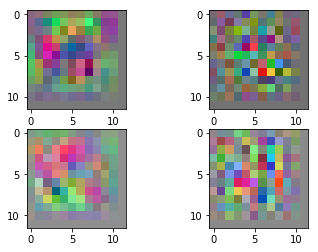

In [34]:
fils_tmp_lvl2=filters_lvl2.eval(session=sess)
fils_tmp_lvl2=fils_tmp_lvl2.reshape((win_size_lvl2,win_size_lvl2,num_fils_lvl1,num_fils_lvl2))
fils_tmp_lvl1=filters_lvl1.eval(session=sess)
print fils_tmp_lvl1.shape
print fils_tmp_lvl2.shape


fils_tmp_lvl1=np.reshape(fils_tmp_lvl1,(win_size*win_size*3,num_fils_lvl1))
fils_tmp = np.zeros((win_size+win_size_lvl2,win_size+win_size_lvl2,3,num_fils_lvl2))

for i in range(win_size_lvl2):
    for j in range(win_size_lvl2):
        fils_proj = np.matmul(fils_tmp_lvl1,fils_tmp_lvl2[i,j,:,:])
        fils_proj = np.reshape(fils_proj,(win_size,win_size,3,num_fils_lvl2))        
        fils_tmp[i:(i+win_size),j:(j+win_size),:,:] = fils_tmp[i:(i+win_size),j:(j+win_size),:,:] + fils_proj

plt.subplot(221)
plt.imshow(stand(fils_tmp[:,:,:,ind]))
plt.subplot(222)
plt.imshow(stand(fils_tmp[:,:,:,ind+1]))
plt.subplot(223)
plt.imshow(stand(fils_tmp[:,:,:,ind+2]))
plt.subplot(224)
plt.imshow(stand(fils_tmp[:,:,:,ind+3]))

